In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt
import pennylane as qml
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [3]:
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
loc_test = np.load('loc_test.npy')

In [4]:
n_qubits = 4
n_layers = 3

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dev = qml.device("lightning.qubit", wires=n_qubits)

DeviceError: Device mixed.qubit does not exist. Make sure the required plugin is installed.

In [6]:
@qml.qnode(dev, interface="torch")
def q_circuit(inputs, weights):
    """A quantum circuit that acts as a feature extractor."""
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [7]:
class QLSTMModel(nn.Module):
    """
    Hybrid Quantum-Classical model for multi-step forecasting.
    A classical LSTM processes the sequence, and its output is fed
    into a quantum circuit for feature extraction, followed by a
    classical layer for multi-step prediction.
    """
    def __init__(self, n_features, n_lstm_units=4, n_qubits=2, num_layers=1, n_layers=1, output_len=72):
        super(QLSTMModel, self).__init__()

        # 1. Classical LSTM Layer
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_lstm_units,
            num_layers=num_layers,
            batch_first=True
        )
        
        # 2. Classical Layer to map LSTM output to Quantum input
        self.classical_to_quantum = nn.Linear(n_lstm_units, n_qubits)
        
        # 3. Quantum Layer
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.q_layer = qml.qnn.TorchLayer(q_circuit, weight_shapes)
        
        # 4. Classical Layer to map quantum output to predictions
        self.quantum_to_output = nn.Linear(n_qubits, output_len)
        
    def forward(self, x):        
        # 1. Pass data through the classical LSTM
        lstm_out, _ = self.lstm(x)
        
        # 2. Extract features from the last timestep
        final_lstm_output = lstm_out[:, -1, :]
        
        # 3. Prepare the data for the quantum circuit
        quantum_input = self.classical_to_quantum(final_lstm_output)
        
        # 4. Pass the features through the quantum circuit
        quantum_features = self.q_layer(quantum_input)
        
        # 5. Map quantum features to output sequence
        output = self.quantum_to_output(quantum_features)
        
        # 6. Apply sigmoid activation to get probabilities
        return torch.sigmoid(output)

In [8]:
def plot_example_predictions(model, X_test, y_test, num_examples=3):
    """Plot example predictions vs actual values"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    with torch.no_grad():
        sample_indices = np.random.choice(len(X_test), num_examples, replace=False)
        plt.figure(figsize=(15, 5 * num_examples))

        for i, idx in enumerate(sample_indices):
            X_sample = torch.tensor(X_test[idx:idx+1]).to(device)
            y_true = y_test[idx]
            y_pred = model(X_sample).cpu().numpy()[0]
            y_pred = (y_pred > 0.5).astype(int)

            plt.subplot(num_examples, 1, i+1)
            hours = np.arange(1, 72 + 1)
            plt.plot(hours, y_true, 'bo-', label='Actual')
            plt.plot(hours, y_pred, 'ro--', label='Predicted')
            plt.title(f'Example {i+1}: Air Quality Prediction (Next 72 Hours)')
            plt.xlabel('Hours Ahead')
            plt.ylabel('Air Quality Class')
            plt.yticks([0, 1], ['Good', 'Poor'])
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.savefig('example_predictions.png', dpi=300, bbox_inches='tight')
        plt.show()

In [9]:
def evaluate_model_per_location_and_hour(model, test_loader, device, location_indices_test, output_seq_len=72):
    """
    Evaluate the model with the needed metrics
    """
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = (outputs > 0.5).float()

            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    preds_flat, labels_flat = all_preds.flatten(), all_labels.flatten()

    # All metrics Required
    accuracy = (preds_flat == labels_flat).mean()
    precision = precision_score(labels_flat, preds_flat, average="binary")
    recall = recall_score(labels_flat, preds_flat, average="binary")
    f1 = f1_score(labels_flat, preds_flat, average="binary")
    conf_matrix = confusion_matrix(labels_flat, preds_flat)

    # Per-location metrics
    unique_locations = np.unique(location_indices_test)
    location_metrics = {}
    for loc in unique_locations:
        idx = (location_indices_test == loc)
        preds_loc, labels_loc = all_preds[idx].flatten(), all_labels[idx].flatten()
        location_metrics[int(loc)] = {
            "accuracy": (preds_loc == labels_loc).mean(),
            "precision": precision_score(labels_loc, preds_loc, average="binary"),
            "recall": recall_score(labels_loc, preds_loc, average="binary"),
            "f1": f1_score(labels_loc, preds_loc, average="binary"),
            "confusion_matrix": confusion_matrix(labels_loc, preds_loc)
        }

    # Per-hour metrics
    hour_metrics = []
    for hour in range(output_seq_len):
        preds_hour, labels_hour = all_preds[:, hour], all_labels[:, hour]
        hour_metrics.append({
            "hour": hour + 1,
            "accuracy": (preds_hour == labels_hour).mean(),
            "precision": precision_score(labels_hour, preds_hour, average="binary"),
            "recall": recall_score(labels_hour, preds_hour, average="binary"),
            "f1": f1_score(labels_hour, preds_hour, average="binary"),
            "confusion_matrix": confusion_matrix(labels_hour, preds_hour)
        })

    return {
        "overall": {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "confusion_matrix": conf_matrix
        },
        "per_location": location_metrics,
        "per_hour": hour_metrics,
        "preds_flat": preds_flat,  
        "labels_flat": labels_flat  
    }

In [10]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

In [11]:
if torch.cuda.is_available():
    print(f"✅ Found GPU: {torch.cuda.get_device_name(0)}. Using CUDA.")
else:
    print("❌ No GPU found. The script will run on the CPU.")

✅ Found GPU: NVIDIA GeForce RTX 3050 Laptop GPU. Using CUDA.


In [12]:
batch_size = 512
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
n_lstm_units = 32
num_layers = 1

model = QLSTMModel(
    n_features=9, 
    n_lstm_units=n_lstm_units,  
    n_qubits=n_qubits,
    num_layers=num_layers,
    n_layers=n_layers,
    output_len=72
)

try:
    model.load_state_dict(torch.load('best_qlstm_model_multistep.pth', weights_only=True))
    print("Model loaded successfully!")
except FileNotFoundError:
    print("Error: Model file 'best_qlstm_model_multistep.pth' not found.")
    print("Please make sure the model training has been completed.")
    raise
except Exception as e:
    print(f"Error loading model: {e}")
    raise

print("\nQuantum-Classical LSTM Model Architecture:")
print(model)

# Evaluate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Model loaded successfully!

Quantum-Classical LSTM Model Architecture:
QLSTMModel(
  (lstm): LSTM(9, 32, batch_first=True)
  (classical_to_quantum): Linear(in_features=32, out_features=4, bias=True)
  (q_layer): <Quantum Torch Layer: func=q_circuit>
  (quantum_to_output): Linear(in_features=4, out_features=72, bias=True)
)


QLSTMModel(
  (lstm): LSTM(9, 32, batch_first=True)
  (classical_to_quantum): Linear(in_features=32, out_features=4, bias=True)
  (q_layer): <Quantum Torch Layer: func=q_circuit>
  (quantum_to_output): Linear(in_features=4, out_features=72, bias=True)
)

In [14]:
print("\nCalculating detailed accuracy metrics...")
metrics = evaluate_model_per_location_and_hour(
    model, test_loader, device, loc_test
)


Calculating detailed accuracy metrics...


In [15]:
overall_metrics = metrics["overall"]
location_metrics = metrics["per_location"]
hour_metrics = metrics["per_hour"]


Per-location accuracy (averaged over all 72 hours):
Location 0: 0.8276
Location 1: 0.8459
Location 2: 0.8261
Location 3: 0.7754
Location 4: 0.7701
Location 5: 0.7678
Location 6: 0.7984
Location 7: 0.8068
Location 8: 0.8318
Location 9: 0.8527
Location 10: 0.8640
Location 11: 0.8250
Location 12: 0.8032
Location 13: 0.8159
Location 14: 0.7916
Location 15: 0.7673
Location 16: 0.7526
Location 17: 0.7027
Location 18: 0.7098
Location 19: 0.7570
Location 20: 0.8244
Location 21: 0.8471
Location 22: 0.8302
Location 23: 0.7692
Location 24: 0.7448
Location 25: 0.7873
Location 26: 0.7893
Location 27: 0.8187
Location 28: 0.8387
Location 29: 0.8493
Location 30: 0.8579
Location 31: 0.8451
Location 32: 0.8282
Location 33: 0.8139
Location 34: 0.7792
Location 35: 0.7709
Location 36: 0.7332
Location 37: 0.7159
Location 38: 0.7398
Location 39: 0.7779
Location 40: 0.7953
Location 41: 0.8332
Location 42: 0.8518
Location 43: 0.8074
Location 44: 0.7625
Location 45: 0.7852
Location 46: 0.7933
Location 47: 0.81

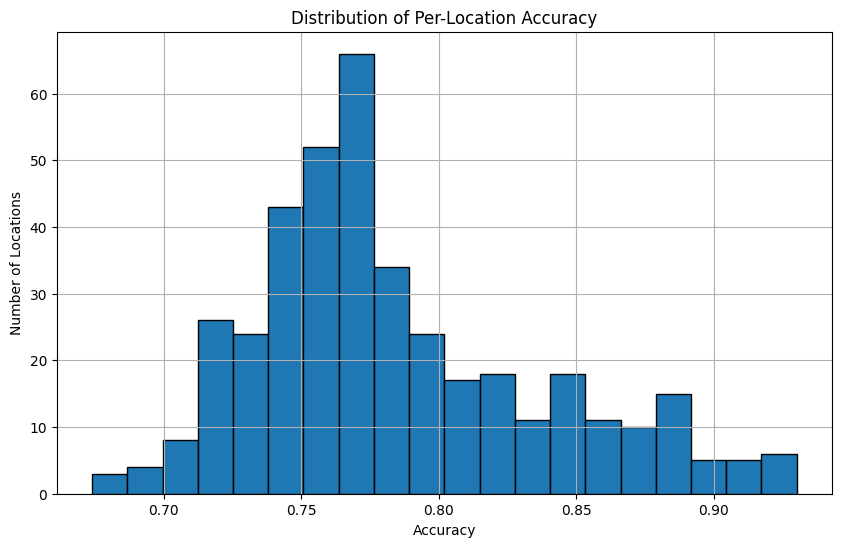

In [16]:
print("\nPer-location accuracy (averaged over all 72 hours):")
for loc in sorted(location_metrics.keys()):
    print(f"Location {loc}: {location_metrics[loc]['accuracy']:.4f}")

# Plot location accuracy distribution
plt.figure(figsize=(10, 6))
plt.hist([loc_metrics['accuracy'] for loc_metrics in location_metrics.values()], bins=20, edgecolor='black')
plt.title('Distribution of Per-Location Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Number of Locations')
plt.grid(True)
plt.savefig('location_accuracy_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


Per-hour accuracy (averaged over all locations):
Hour 1: 0.9576
Hour 2: 0.9592
Hour 3: 0.9430
Hour 4: 0.9231
Hour 5: 0.9027
Hour 6: 0.8791
Hour 7: 0.8461
Hour 8: 0.8400
Hour 9: 0.8498
Hour 10: 0.8445
Hour 11: 0.8468
Hour 12: 0.8451
Hour 13: 0.8234
Hour 14: 0.8143
Hour 15: 0.8020
Hour 16: 0.7856
Hour 17: 0.7679
Hour 18: 0.7564
Hour 19: 0.7526
Hour 20: 0.7604
Hour 21: 0.7704
Hour 22: 0.7806
Hour 23: 0.7891
Hour 24: 0.7937
Hour 25: 0.7957
Hour 26: 0.7951
Hour 27: 0.7939
Hour 28: 0.7903
Hour 29: 0.7883
Hour 30: 0.7794
Hour 31: 0.7541
Hour 32: 0.7577
Hour 33: 0.7794
Hour 34: 0.7915
Hour 35: 0.7982
Hour 36: 0.8008
Hour 37: 0.7841
Hour 38: 0.7778
Hour 39: 0.7666
Hour 40: 0.7509
Hour 41: 0.7354
Hour 42: 0.7307
Hour 43: 0.7331
Hour 44: 0.7427
Hour 45: 0.7525
Hour 46: 0.7611
Hour 47: 0.7661
Hour 48: 0.7690
Hour 49: 0.7701
Hour 50: 0.7708
Hour 51: 0.7687
Hour 52: 0.7652
Hour 53: 0.7643
Hour 54: 0.7551
Hour 55: 0.7281
Hour 56: 0.7259
Hour 57: 0.7509
Hour 58: 0.7641
Hour 59: 0.7720
Hour 60: 0.7741

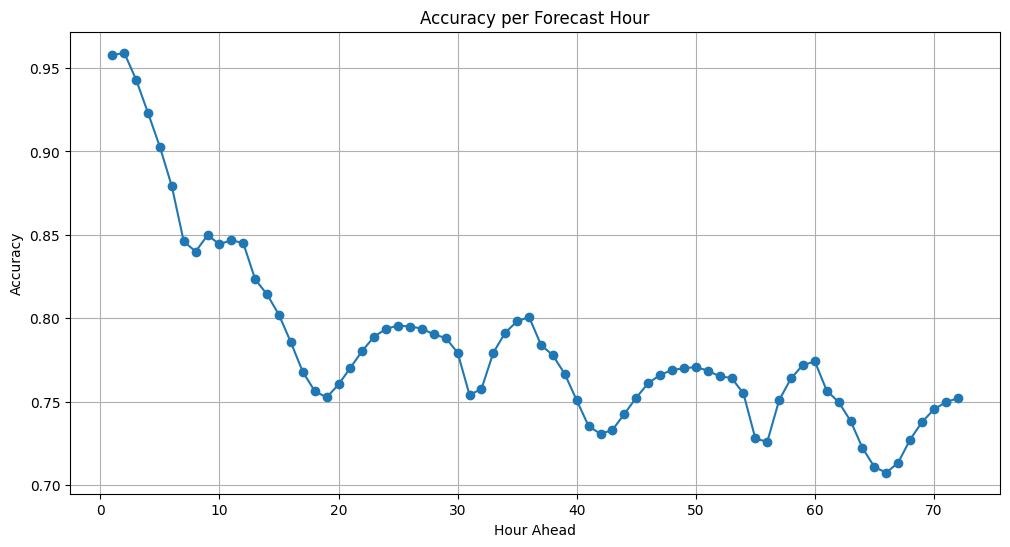

In [17]:
print("\nPer-hour accuracy (averaged over all locations):")
for hour_metrics_dict in hour_metrics:
    hour = hour_metrics_dict["hour"]
    accuracy = hour_metrics_dict["accuracy"]
    print(f"Hour {hour}: {accuracy:.4f}")

# Plot hour accuracy
plt.figure(figsize=(12, 6))
plt.plot([hm["hour"] for hm in hour_metrics], [hm["accuracy"] for hm in hour_metrics], marker='o')
plt.title('Accuracy per Forecast Hour')
plt.xlabel('Hour Ahead')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('hour_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()


Calculating detailed accuracy metrics...

Overall Confusion Matrix:


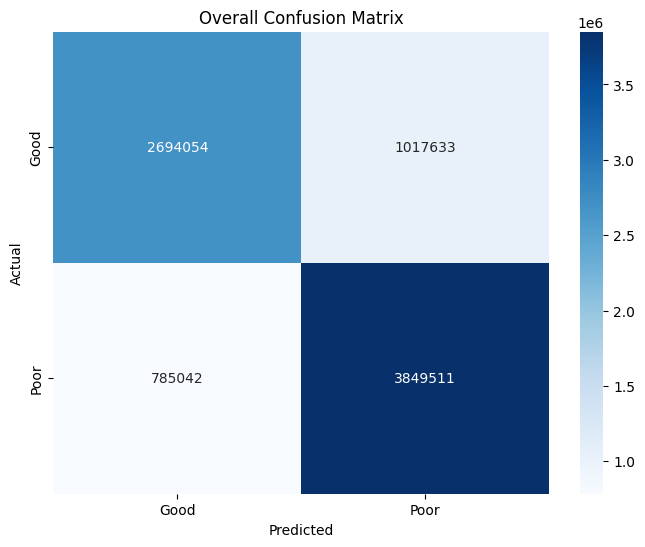


Overall Metrics:
Accuracy: 0.7840
Precision: 0.7909
Recall: 0.8306
F1 Score: 0.8103


In [18]:
# After getting metrics
print("\nCalculating detailed accuracy metrics...")

# Extract metrics
overall_metrics = metrics["overall"]
location_metrics = metrics["per_location"]
hour_metrics = metrics["per_hour"]
preds_flat = metrics["preds_flat"]
labels_flat = metrics["labels_flat"]

# Plot overall confusion matrix
print("\nOverall Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(overall_metrics['confusion_matrix'], 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=['Good', 'Poor'],
            yticklabels=['Good', 'Poor'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Overall Confusion Matrix')
plt.savefig('overall_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Print overall metrics
print("\nOverall Metrics:")
print(f"Accuracy: {overall_metrics['accuracy']:.4f}")
print(f"Precision: {overall_metrics['precision']:.4f}")
print(f"Recall: {overall_metrics['recall']:.4f}")
print(f"F1 Score: {overall_metrics['f1']:.4f}")


Generating example predictions...


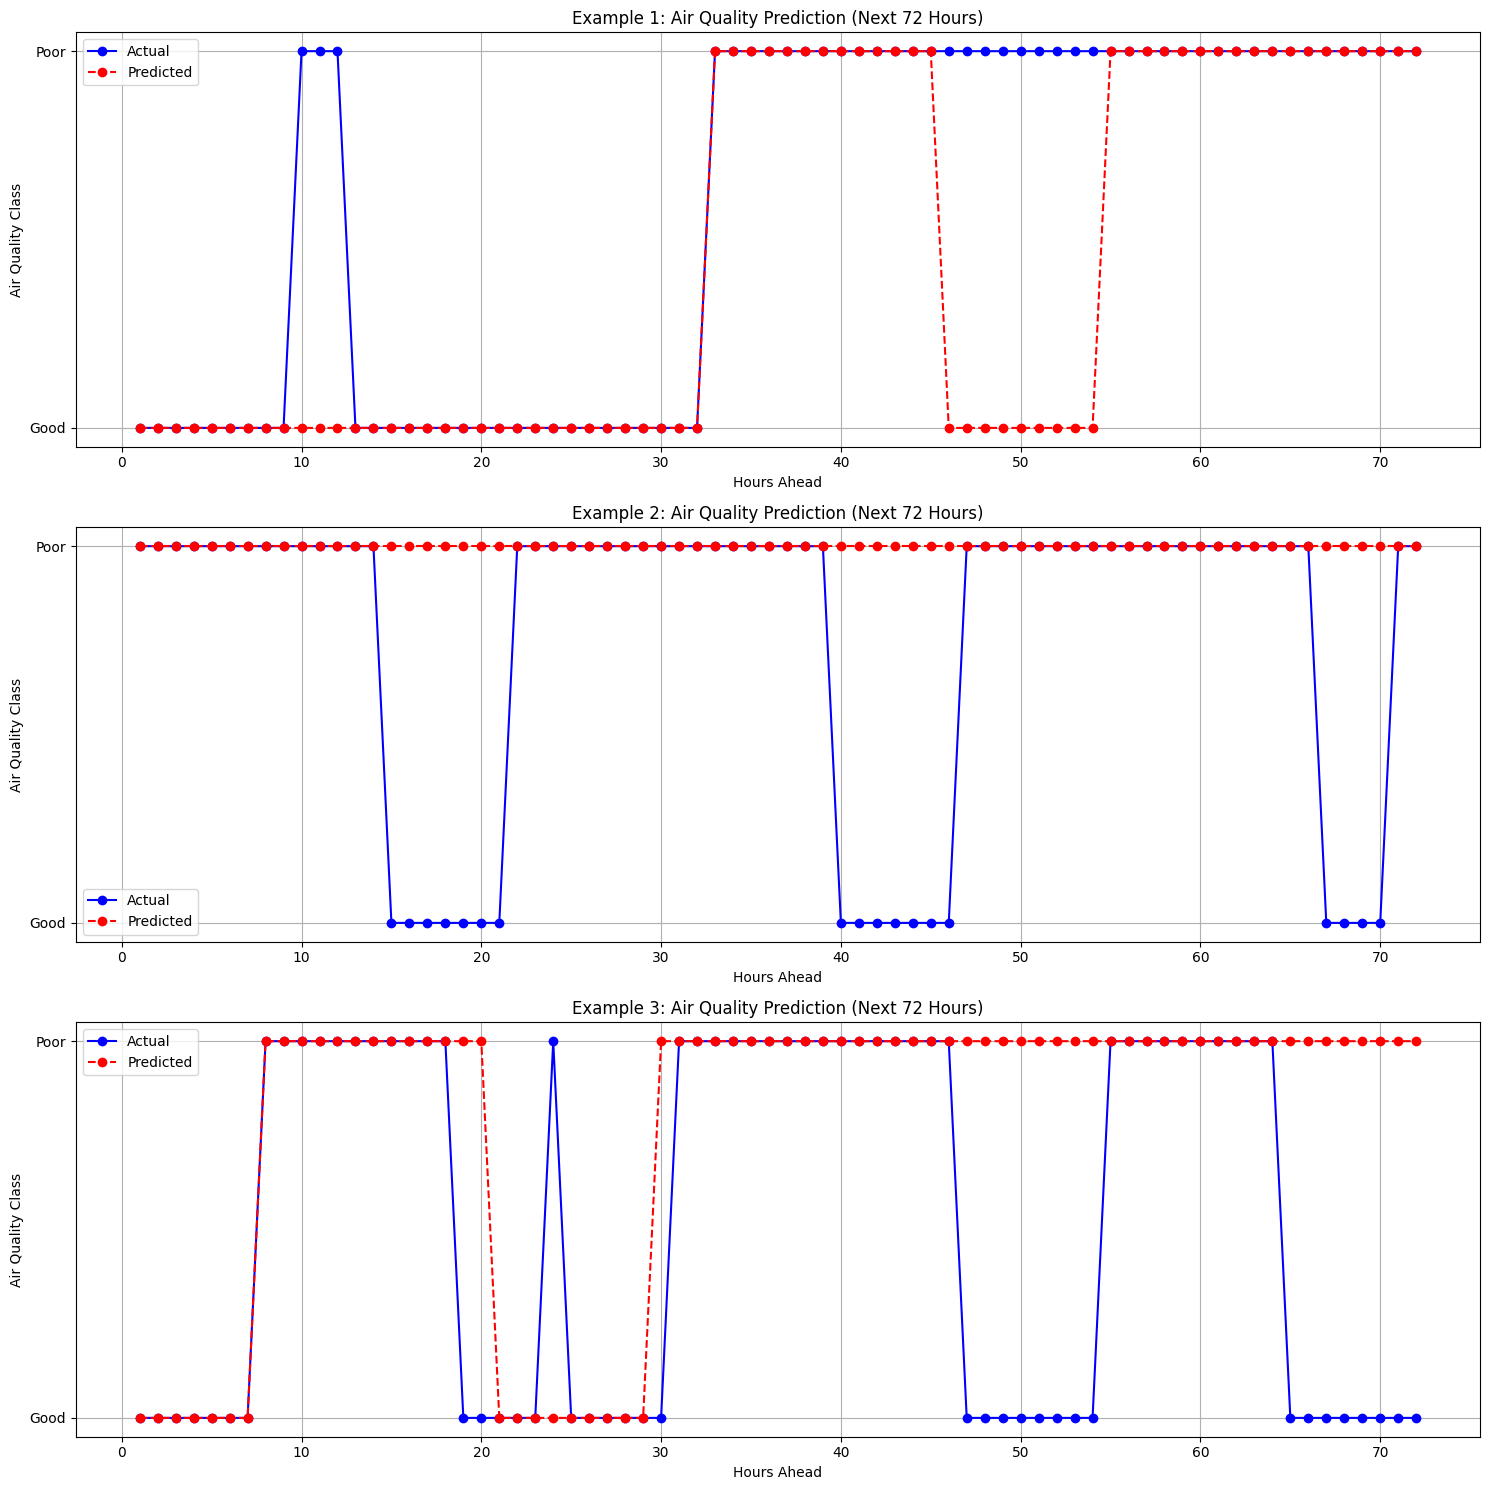


Testing complete. Results saved.


In [19]:
print("\nGenerating example predictions...")
plot_example_predictions(model, X_test, y_test, num_examples=3)

print("\nTesting complete. Results saved.")